# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
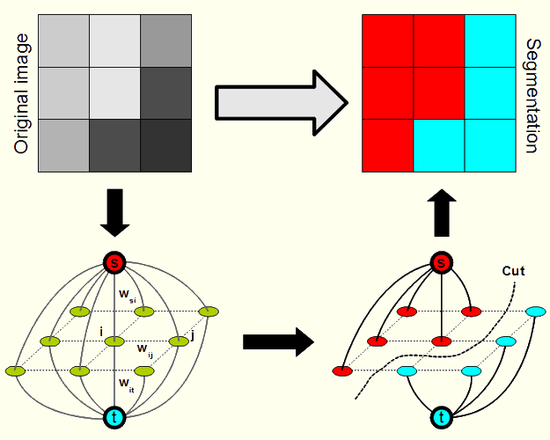

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

# Algorithm

 - Given a image we need to segment this image into 2 parts i.e. foreground and background.
 - Take a image and draw a rectangle which cover the foreground part.
 - Take a mask of same size as image and assign all values to 0.
 - Update all the pixel which lies in rectangle to 1 (1 means it belongs to foregorund and 0 means it belongs to background).
 - Extract all the foreground pixels in a list and background pixels in another list.
 - Fit two GMMs with this pixel values one for foreground and another for background.
 - Now make a graph with a foreground node , a background node and a node for each pixels.
 - Now we have draw edges between nodes and assign weights.
 - To assign weights from foreground to pixel node we will use energy functions.
 - Similarly, we have to draw edges between neighbors pixels we can use 4-neighbourhood setting or 8-neighbourhood setting.
 - Once our graph is completed, we will apply the mincut algorithm on the graph which will separate our foreground and background pixels.
 - Once we got our new mask, we can iteratively perform above steps to fine tune our results.

### Importing the required libraries

In [14]:
import numpy as np
import cv2
import networkx as nx
import os
from sklearn.mixture import GaussianMixture
from networkx.algorithms.flow import shortest_augmenting_path
import matplotlib.pyplot as plt

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

### Evaluation Metrics

In [3]:
## mask and ground_truth are gray scale so if they are not in gray scale convert to gray scale
def pixel_accuracy(mask, ground_truth):
    
    m = mask.shape[0]
    n = mask.shape[1]
    
    correct_classified_pixels = 0
    for i in range(m):
        for j in range(n):
            if mask[i][j]==ground_truth[i][j]:
                correct_classified_pixels += 1
    
    total_pixels = m * n 
    
    return correct_classified_pixels/total_pixels

def jaccard_index(mask, ground_truth):
    
    m = mask.shape[0]
    n = mask.shape[1]
    
    f_intersection = 0
    f_union = 0
    b_intersection = 0
    b_union = 0 
    
    for i in range(m):
        for j in range(n):
            if mask[i][j]==0 and ground_truth[i][j]==0:
                b_intersection += 1
                b_union += 1
            elif mask[i][j] == 1 and ground_truth[i][j]==1:
                f_intersection += 1
                f_union +=1
            else:
                b_union +=1
                f_union +=1
    
    f_j = f_intersection/f_union
    b_j = b_intersection/b_union
    
    j_index = (f_j + b_j)/2.0
    
    return j_index

def dice_similarity(mask,ground_truth):
    
    f_total = 0
    b_total = 0 
    
    f_intersection = 0
    b_intersection = 0
    
    f_total = np.where(mask==1)[0].shape[0] + np.where(ground_truth==1)[0].shape[0]
    b_total = np.where(mask==0)[0].shape[0] + np.where(ground_truth==0)[0].shape[0]
    
    m = mask.shape[0]
    n = mask.shape[1]
    
    for i in range(m):
        for j in range(n):
            if mask[i][j]==0 and ground_truth[i][j]==0:
                b_intersection += 1
            if mask[i][j] == 1 and ground_truth[i][j]==1:
                f_intersection += 1
    
    f_dice = 2*f_intersection / f_total
    b_dice = 2*b_intersection / b_total
    
    dice = (f_dice + b_dice)/2.0
    
    return dice    

### Energy Functions

In [4]:
def calculate_energy(image, gmm):
    
    m = image.shape[0]
    n = image.shape[1]
    
    energy = np.zeros((m,n))
    
    for i in range(m):
        for j in range(n):
            img = image[i][j].reshape(1,-1)
            pred = gmm.predict(img)
            cov = gmm.covariances_[pred[0]]
            mean = gmm.means_[pred[0]]
            weight = gmm.weights_[pred[0]]
            diff = img - mean
            edge_weight = -np.log(weight)
            edge_weight = edge_weight + 0.5*np.log(np.linalg.det(cov))
            edge_weight = edge_weight + 0.5*np.dot(diff, np.dot(np.linalg.inv(cov), diff.T))
            energy[i][j] = edge_weight
    
    return energy    

In [6]:
def find_beta(image, neighbors):
    
    m = image.shape[0]
    n = image.shape[1]
    beta = 0
    n_edges = 0
    
    for i in range(m):
        for j in range(n):
            for dim in neighbors:
                x = dim[0]
                y = dim[1]
                if (i+x>=0 and i+x<m) and (j+y>=0 and j+y<n):
                    beta += np.sum(np.square(np.subtract(image[i][j],image[i+x][j+y])))
                    n_edges+=1
                    
    beta=n_edges/(2*beta)
    
    return beta

### Plotting Images

In [5]:
def plot_images(image, mask, ground_truth):
    
    fig = plt.figure(figsize=(20, 20))
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig.add_subplot(1, 4, 1)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Original Image")

    fig.add_subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Masked Image")
    
    fig.add_subplot(1, 4, 3)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')
    plt.title("Ground Truth")

    seg_img = img_rgb
    seg_img[np.where(mask==0)]=0

    fig.add_subplot(1, 4, 4)
    plt.imshow(seg_img)
    plt.axis('off')
    plt.title("Segmented Image")

    plt.show()
    

In [59]:
neighbors = [[-1, 0],[0, -1],[1, 0],[0, 1]]

In [48]:
def run(filename, iterations, gamma, scale, gmm_components):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }
    
   
    img = cv2.imread(filename)
    
    
    width = int(img.shape[1] * scale / 100)
    height = int(img.shape[0] * scale / 100)
     
    img = cv2.resize(img, (width, height))    
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
#     cv2.namedWindow('Segmented image')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented output', output)
        cv2.imshow('Input Image', img)
#         cv2.imshow('Segmented output', mask)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            x, y, w, h=EventObj.FLAGS['RECT']
                
            mask[y:y+h, x:x+w] = np.ones((h,w))
            
            image = img
            im = img
            beta = find_beta(image, neighbors)  
#             print("Enter pressed, beta")
            for it in range(iterations):
                
                m = image.shape[0]
                n = image.shape[1]
                
                foreground_list = []
                background_list = []

                graph = nx.Graph()

                graph.add_node("foreground")
                graph.add_node("background")


                for i in range(m):
                    for j in range(n):
                        graph.add_node((i,j))
                        
                for i in range(m):
                    for j in range(n):
                        if mask[i][j]==1:
                            foreground_list.append(image[i][j])
                        else:
                            background_list.append(image[i][j])
                        
#                 print("ForeGround List Length :",len(foreground_list))
                            
                foreground_list = np.array(foreground_list)
                background_list = np.array(background_list)

#                 print("Foreground and background pixels extracted")
                
                gmm_foreground = GaussianMixture(n_components=gmm_components)
                gmm_background = GaussianMixture(n_components=gmm_components)

                gmm_foreground.fit(foreground_list)
                gmm_background.fit(background_list)
                
#                 print("GMM fitting Done")

                foreground_energy = calculate_energy(image,gmm_foreground)
                background_energy = calculate_energy(image,gmm_background)

#                 print("Energy Calculated")


                for i in range(m):
                    for j in range(n):
                        if mask[i][j]==0:
                            graph.add_edge("foreground", (i,j))
                            graph.add_edge("background", (i,j), capacity=0)
                        else:
                            graph.add_edge("foreground", (i,j), capacity=foreground_energy[i][j])
                            graph.add_edge("background", (i,j), capacity=background_energy[i][j])

                        for dim in neighbors:
                            x = dim[0]
                            y = dim[1]
                            if (i+x>=0 and i+x<m) and (j+y>=0 and j+y<n):
                                dif = np.sum(np.square(np.subtract(image[i][j],image[i+x][j+y])))
                                val=gamma*np.exp(-beta*dif)
                                graph.add_edge((i, j), (i+x, j+y), capacity=val)

#                 print("Graph Completed")
                
                _, partition = nx.minimum_cut(graph, "background", "foreground", flow_func=shortest_augmenting_path)
                reachable, _ = partition
                
#                 print("Points Extracted")
                temp = np.zeros((m, n))
                for r in reachable:
                    if r!="background":
                        x = r[0]
                        y = r[1]
                        temp[x][y] = 1
                
                mask = temp
            return mask
                   
            
#             EventObj.flags = FLAGS
#             mask2 = np.where((mask == 1), 255, 0).astype('uint8')
#             output = cv2.bitwise_and(img2, img2, mask = mask2)
            
#             print("Press esc to see results")

In [49]:
def GrabCut(filename, ground_truth,iterations,gamma,scale, gmm_components=2):
    mask = run(filename,iterations,gamma,scale,gmm_components)
    img = cv2.imread(filename)
    ground_truth = cv2.imread(ground_truth,0)
    width = int(ground_truth.shape[1] * scale / 100)
    height = int(ground_truth.shape[0] * scale / 100)
    ground_truth = cv2.resize(ground_truth, (width, height))
    img = cv2.resize(img, (width, height))
    ground_truth = ground_truth/255                               
    plot_images(img, mask, ground_truth)
    print("Accuracy : ", pixel_accuracy(mask, ground_truth))
    print("Jacard Similarity : ", jaccard_index(mask,ground_truth))
    print("Dice Similarity : ", dice_similarity(mask, ground_truth))

#     pix_acc = pixel_accuracy(mask, ground_truth)
#     jac_sim = jaccard_index(mask,ground_truth)
#     dice_sim = dice_similarity(mask, ground_truth)
    
    cv2.destroyAllWindows()
#     return pix_acc, jac_sim, dice_sim
    

In [17]:
original_images = os.listdir("../images/")
ground_truth_images = os.listdir("../ground_truth/")
original_images.sort()
ground_truth_images.sort()
print(original_images)
print(ground_truth_images)

['banana1.jpg', 'banana2.jpg', 'banana3.jpg', 'book.jpg', 'bool.jpg', 'bush.jpg', 'ceramic.jpg', 'cross.jpg', 'doll.jpg', 'elefant.jpg', 'flower.jpg', 'fullmoon.jpg', 'grave.jpg', 'llama.jpg', 'memorial.jpg', 'music.jpg', 'person1.jpg', 'person2.jpg', 'person3.jpg', 'person4.jpg', 'person5.jpg', 'person6.jpg', 'person7.jpg', 'person8.jpg', 'scissors.jpg', 'sheep.jpg', 'stone1.jpg', 'stone2.jpg', 'teddy.jpg', 'tennis.jpg']
['banana1.bmp', 'banana2.bmp', 'banana3.bmp', 'book.bmp', 'bool.bmp', 'bush.bmp', 'ceramic.bmp', 'cross.bmp', 'doll.bmp', 'elefant.bmp', 'flower.bmp', 'fullmoon.bmp', 'grave.bmp', 'llama.bmp', 'memorial.bmp', 'music.bmp', 'person1.bmp', 'person2.bmp', 'person3.bmp', 'person4.bmp', 'person5.bmp', 'person6.bmp', 'person7.bmp', 'person8.bmp', 'scissors.bmp', 'sheep.bmp', 'stone1.bmp', 'stone2.bmp', 'teddy.bmp', 'tennis.bmp']


# Accuracies For all 30 images

In [18]:
pix_acc_list = [0.9674479166666666, 0.9765625, 0.8731192129629629, 0.9393084490740741, 0.8117758784425451, 0.8606172839506173, 0.9601779513888888, 0.6270781893004115, 0.9665959703075292, 0.9267216435185185, 0.9882304526748971, 0.9752525252525253, 0.8773662551440329, 0.9663781428487311, 0.9707407407407408, 0.9820240162037037, 0.9306172839506173, 0.9887654320987654, 0.8995061728395062, 0.9447325102880658, 0.9747736625514404, 0.9383539094650206, 0.9698353909465021, 0.9772135416666666, 0.8876591435185185, 0.9939506172839506, 0.8074363425925926, 0.9924768518518519, 0.9766683143845774, 0.9424586288416076]

jac_sim_list = [0.919736328597494, 0.9375619887463977, 0.7381482958034014, 0.8760399655045232, 0.5538301489322321, 0.5242167546398774, 0.91257512731062, 0.31353909465020574, 0.9312538142422082, 0.8520105243307652, 0.9636801287970844, 0.8384988143743288, 0.43868312757201644, 0.8933062238197548, 0.9061041174997118, 0.9614685904691916, 0.8357021184680069, 0.9598754296697031, 0.680684377897045, 0.8185731776514629, 0.8221832279007921, 0.690165542631557, 0.7736334753028757, 0.9317806018289073, 0.6739996764498308, 0.9431263246673032, 0.4037181712962963, 0.979814825797746, 0.9345450940357816, 0.748494151009363]

dice_sim_list = [0.9611218226148308, 0.971795104355659, 0.8493276018319063, 0.9366221815946472, 0.684563321558877, 0.6291898501251536, 0.9572650186814643, 0.38540138600839696, 0.966701676565278, 0.9218157844273811, 0.984167587764345, 0.9070075296258512, 0.46733888645330995, 0.9461604719964374, 0.9547891153311208, 0.9828183822541716, 0.9119822446529344, 0.9822095371501545, 0.7929190836583868, 0.90072120322253, 0.9051675969895088, 0.8002862672620599, 0.8663153236597625, 0.967310849544842, 0.791345447953886, 0.973031578402856, 0.44673016889458095, 0.9923117428024751, 0.9718972898221858, 0.8480953984882273]

## Average

In [19]:
print("Average Pixel Accuracy : ", np.mean(np.array(pix_acc_list)))
print("Average Jaccard Similarity : ",np.mean(np.array(jac_sim_list)))
print("Average Dice Similarity : ",np.mean(np.array(dice_sim_list)))

Average Pixel Accuracy :  0.9297948310252175
Average Jaccard Similarity :  0.7918983079965495
Average Dice Similarity :  0.8552136484564408


# Top 4 results

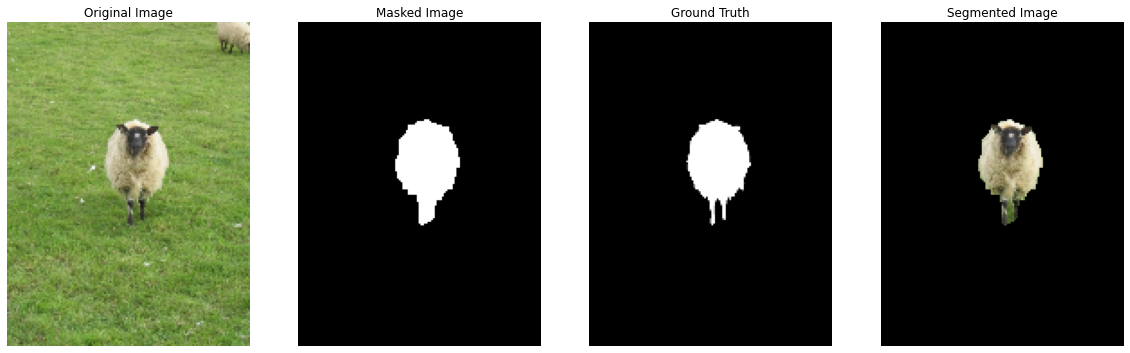

Accuracy :  0.9939917695473252
Jacard Similarity :  0.9435130833469416
Dice Similarity :  0.9730734451839292
CPU times: user 32.9 s, sys: 12.1 s, total: 45 s
Wall time: 23.1 s


In [107]:
%%time
filename = "../images/"+ original_images[25]
ground_truth = "../ground_truth/"+ground_truth_images[25]
GrabCut(filename, ground_truth, 1, 50, 30)

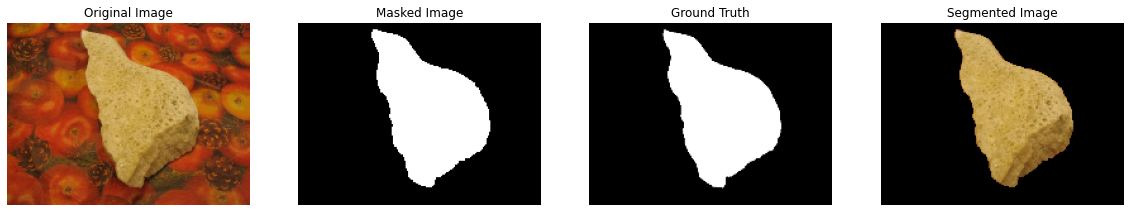

Accuracy :  0.9924406828703703
Jacard Similarity :  0.9797200254417828
Dice Similarity :  0.9922132408766025
CPU times: user 42.5 s, sys: 14 s, total: 56.6 s
Wall time: 31.4 s


In [109]:
%%time
filename = "../images/"+ original_images[27]
ground_truth = "../ground_truth/"+ground_truth_images[27]
GrabCut(filename, ground_truth, 1, 50, 30)

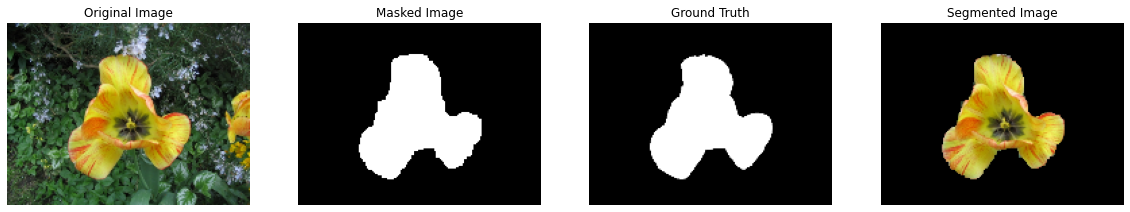

Accuracy :  0.9909876543209877
Jacard Similarity :  0.9718730170403707
Dice Similarity :  0.9885518651644809
CPU times: user 1min 6s, sys: 23.2 s, total: 1min 29s
Wall time: 52.2 s


In [111]:
%%time
filename = "../images/"+ original_images[10]
ground_truth = "../ground_truth/"+ground_truth_images[10]
GrabCut(filename, ground_truth, 2, 50, 30)

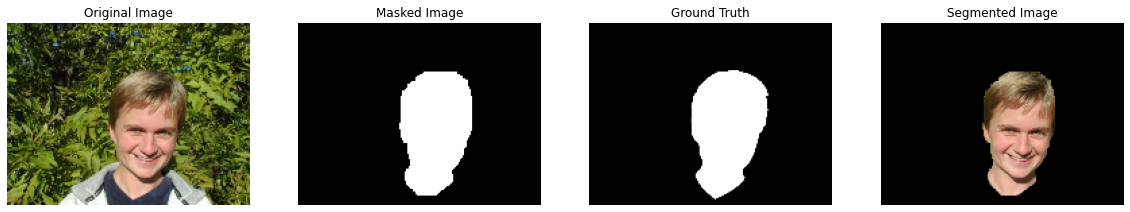

Accuracy :  0.9883127572016461
Jacard Similarity :  0.9582706004758517
Dice Similarity :  0.9813065109936328
CPU times: user 1min 29s, sys: 36 s, total: 2min 5s
Wall time: 59.7 s


In [125]:
%%time
filename = "../images/"+ original_images[17]
ground_truth = "../ground_truth/"+ground_truth_images[17]
GrabCut(filename, ground_truth, 3, 50, 30)

# Bottom 2 results

Draw the rectangle first.


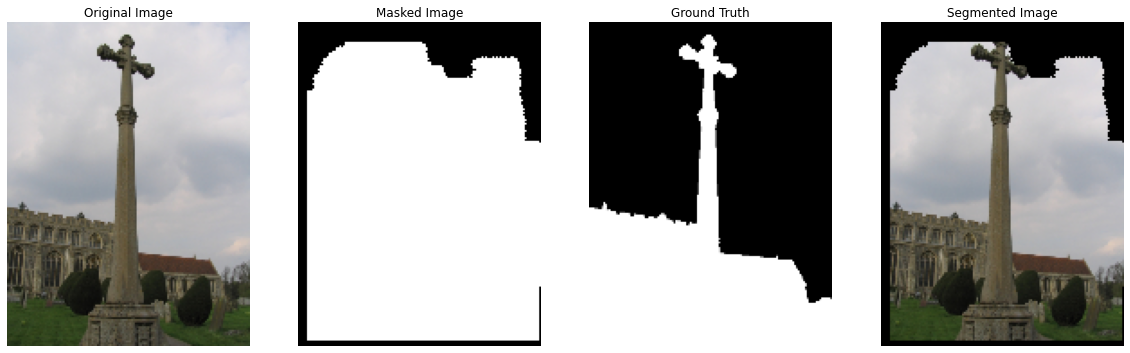

Accuracy :  0.4736213991769547
Jacard Similarity :  0.29907943552986077
Dice Similarity :  0.45448447812147186
CPU times: user 1min 14s, sys: 14 s, total: 1min 28s
Wall time: 1min 55s


In [32]:
%%time
filename = "../images/"+ original_images[7]
ground_truth = "../ground_truth/"+ground_truth_images[7]
GrabCut(filename, ground_truth, 1, 50,30)

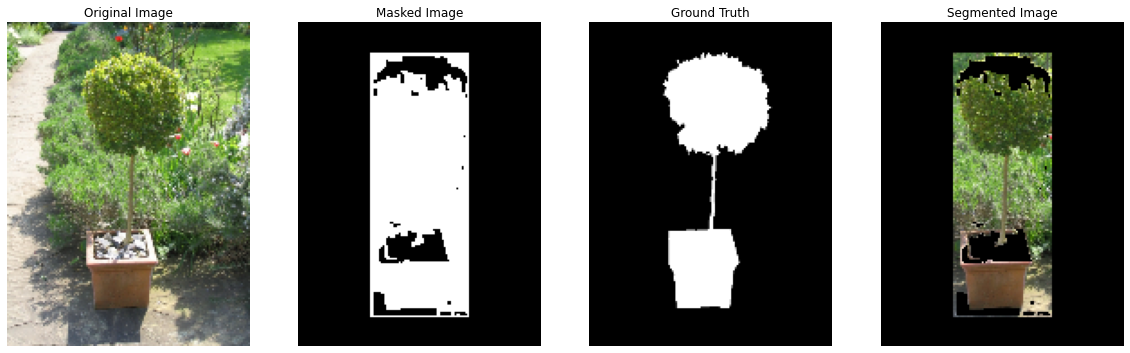

Accuracy :  0.7898765432098765
Jacard Similarity :  0.5609554137985533
Dice Similarity :  0.7000915196732925
CPU times: user 1min 11s, sys: 29.2 s, total: 1min 40s
Wall time: 57.9 s


In [28]:
%%time
filename = "../images/"+ original_images[5]
ground_truth = "../ground_truth/"+ground_truth_images[5]
GrabCut(filename, ground_truth, 2,2, 30)

# Question And Answers

### 1. The number of iterations of GMM updating and energy minimization.

Answer : In the below image I have checked effect of number of iterations and found out that when we increase the number of iterations we get more accurate image. As can be seen from below table that the accuracy and similarity between segmented image and ground truth is increased when we increased number of iterations.

| Number of Iterations | Pixel Accuracy | Jaccard Similarity | Dice Similarity | 
| :- | -: | :-: | :-: |
| 1 | 0.9690867337926161  | 0.9018419460225853  | 0.9511283502137892 |
| 3 | 0.9797444503326856 | 0.9320312220264668 | 0.9692566446153703 |



#### Number of iterations  = 1

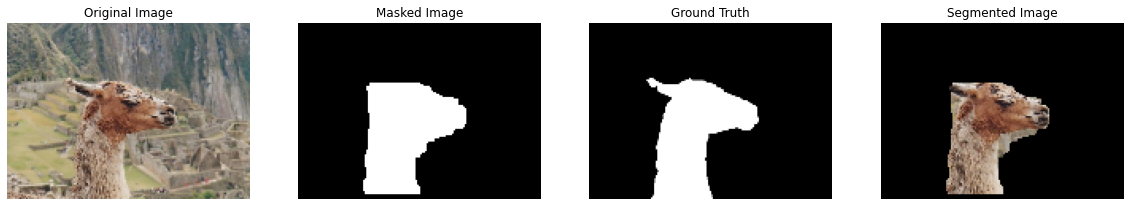

Accuracy :  0.9690867337926161
Jacard Similarity :  0.9018419460225853
Dice Similarity :  0.9511283502137892
CPU times: user 33.1 s, sys: 11.1 s, total: 44.2 s
Wall time: 30.6 s


In [38]:
%%time
filename = "../images/"+ original_images[13]
ground_truth = "../ground_truth/"+ground_truth_images[13]
GrabCut(filename, ground_truth, 1,50, 30)

#### Number of iterations  = 3

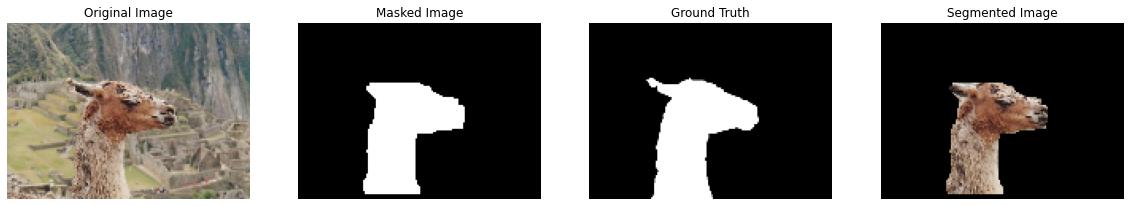

Accuracy :  0.9797444503326856
Jacard Similarity :  0.9320312220264668
Dice Similarity :  0.9692566446153703
CPU times: user 1min 20s, sys: 30.7 s, total: 1min 51s
Wall time: 1min 2s


In [44]:
%%time
filename = "../images/"+ original_images[13]
ground_truth = "../ground_truth/"+ground_truth_images[13]
GrabCut(filename, ground_truth, 3,50, 30)

### 2. Different ways to represent probabilities other than GMMs. 4-neighborhood or 8-neighborhood in your pairwise term.

Answer : We can use simple Gaussian Distribution (for gray scale image) to represent probablities of foreground and background of the image. Also, we can use weighted k-means algorithm to represent probablities of both the classes.

Their is no significant change wheather we use 4-neighbourhood setting or 8-neighbourhood setting. Their is very slight increase in accuracy in case of 8-neighbourhood setting.

| Number of neighbourhood | Pixel Accuracy | Jaccard Similarity | Dice Similarity | 
| :- | -: | :-: | :-: |
| 4 | 0.9869547325102881  | 0.9533700472127444  | 0.9787413903609192 |
| 8 | 0.9892592592592593 | 0.96215333968407 | 0.9822739704612882 |

Draw the rectangle first.


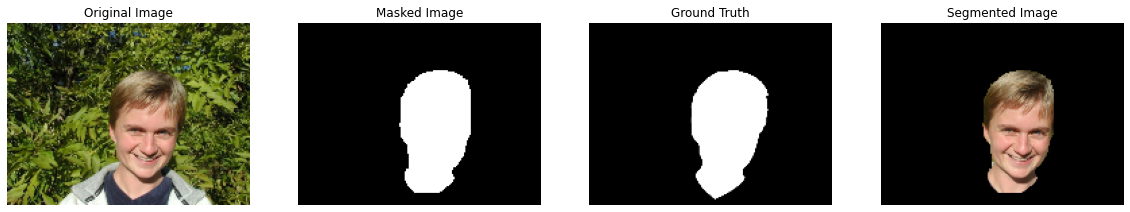

Accuracy :  0.9869547325102881
Jacard Similarity :  0.9533700472127444
Dice Similarity :  0.9787413903609192
CPU times: user 38.4 s, sys: 14.1 s, total: 52.5 s
Wall time: 36.6 s


In [83]:
%%time
neighbors = [[-1, 0],[0, -1],[1, 0],[0, 1]]
filename = "../images/"+ original_images[17]
ground_truth = "../ground_truth/"+ground_truth_images[17]
GrabCut(filename, ground_truth, 1,10, 30)

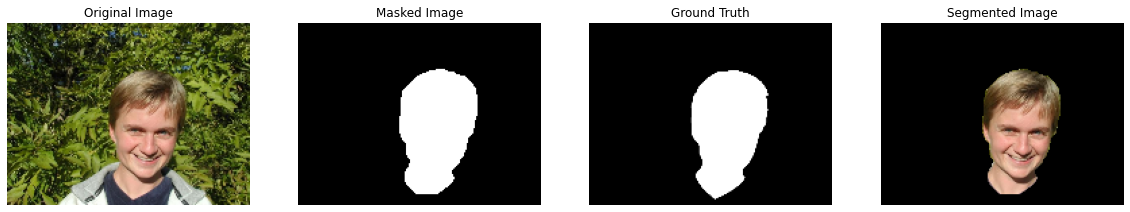

Accuracy :  0.9892592592592593
Jacard Similarity :  0.96215333968407
Dice Similarity :  0.9822739704612882
CPU times: user 46.4 s, sys: 19.5 s, total: 1min 5s
Wall time: 39.6 s


In [80]:
%%time
neighbors = [[-1, 0],[0, -1],[1, 0],[0, 1],[-1,-1],[1,1],[-1,1],[1,-1]]
filename = "../images/"+ original_images[17]
ground_truth = "../ground_truth/"+ground_truth_images[17]
GrabCut(filename, ground_truth, 1,10, 30)
neighbors = [[-1, 0],[0, -1],[1, 0],[0, 1]]

### 3. The number of mixture components in your GMM.

Answer : In the below image I have checked effect of number of GMM components and found out that when we increase the number of GMM components we get more detailed image. We get more colour in images when number of components in GMM are high. For example, in below case the eyes are classified as background when use one component for GMM and when GMM components are increased to 5 we got the more accurate result.

| Number of GMM components | Pixel Accuracy | Jaccard Similarity | Dice Similarity | 
| :- | -: | :-: | :-: |
| 1 | 0.9627960410038883  | 0.9228587997153976  | 0.9621402979368414 |
| 5 | 0.9785259809119831 | 0.9549441072796061 | 0.979105316643589 |


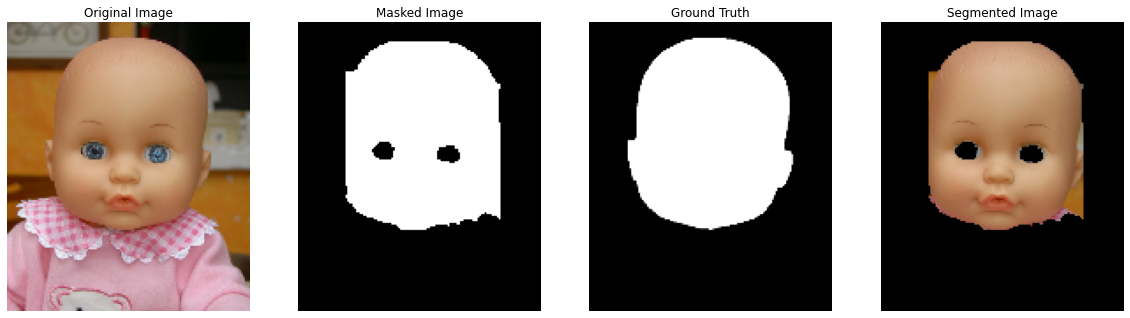

Accuracy :  0.9627960410038883
Jacard Similarity :  0.9228587997153976
Dice Similarity :  0.9621402979368414
CPU times: user 35.4 s, sys: 11.2 s, total: 46.6 s
Wall time: 30.7 s


In [57]:
%%time
filename = "../images/"+ original_images[8]
ground_truth = "../ground_truth/"+ground_truth_images[8]
GrabCut(filename, ground_truth, 1,20, 30,1)

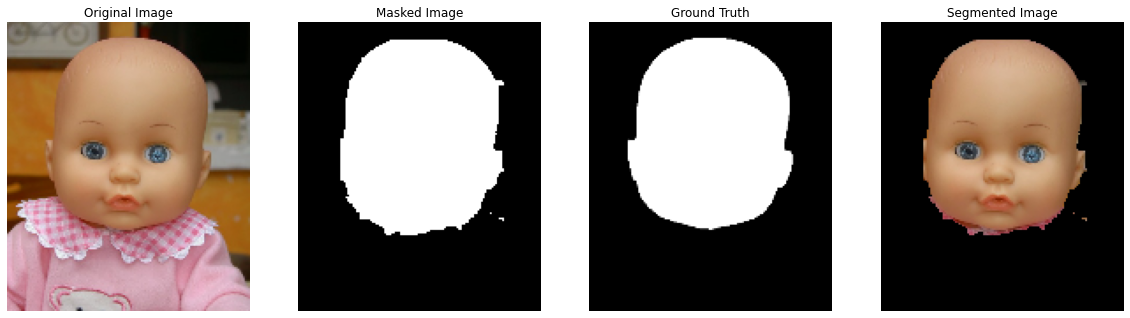

Accuracy :  0.9785259809119831
Jacard Similarity :  0.9549441072796061
Dice Similarity :  0.979105316643589
CPU times: user 47.5 s, sys: 19.7 s, total: 1min 7s
Wall time: 37.3 s


In [58]:
%%time
filename = "../images/"+ original_images[8]
ground_truth = "../ground_truth/"+ground_truth_images[8]
GrabCut(filename, ground_truth, 1,20, 30,5)

### 4. Effect of a tight initial bounding box or a loose bounding box.
Answer : The Grabcut algorithm assumes that the foreground points only lies in the bounding box, so if we use tight bounding box then we may loose some of the foreground pixels outside the bounding box. Hard assignment of all the pixels within the bounding box to the foreground causes the algorithm to perform not optimally for few initial iterations.

When we use loose bounding box, we can also consider the pixel outside the bounding box belonging to the foreground. This helps the algorithm to perfrom better segmentation since there is no need of assigning all the pixels within the bounding box to the foreground as some pixels in the bounding box may also belong to the background.

### 5. The choice of gamma.
Answer : The value of gamma is used to calculate the edge weight between pixel nodes of the graph. When contrast of foregorund and background in a image is not high then our gamma value should be low to get the accurate and when the contrast of foreground and background is very different than using high gamma value will give more clear and accurate results.

| Gamma Value| Pixel Accuracy | Jaccard Similarity | Dice Similarity | 
| :- | -: | :-: | :-: |
| 10 | 0.9600694444444444  | 0.8893621740807269  | 0.9423730321905255 |
| 100 | 0.9662543402777778 | 0.9018668787115478 | 0.9504435797999062 |

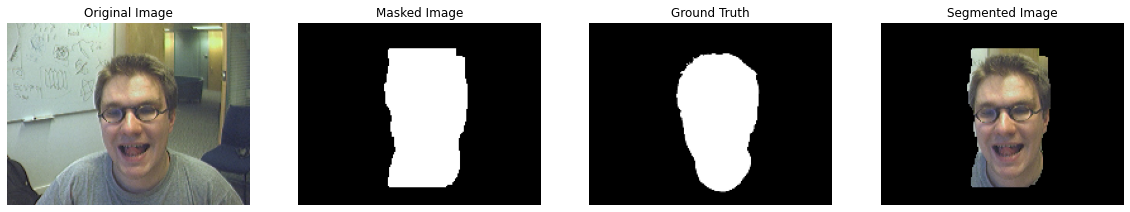

Accuracy :  0.9600694444444444
Jacard Similarity :  0.8893621740807269
Dice Similarity :  0.9423730321905255
CPU times: user 1min 22s, sys: 36.7 s, total: 1min 59s
Wall time: 1min 22s


In [101]:
%%time
filename = "../images/"+ original_images[23]
ground_truth = "../ground_truth/"+ground_truth_images[23]
GrabCut(filename, ground_truth, 1,10, 30,5)

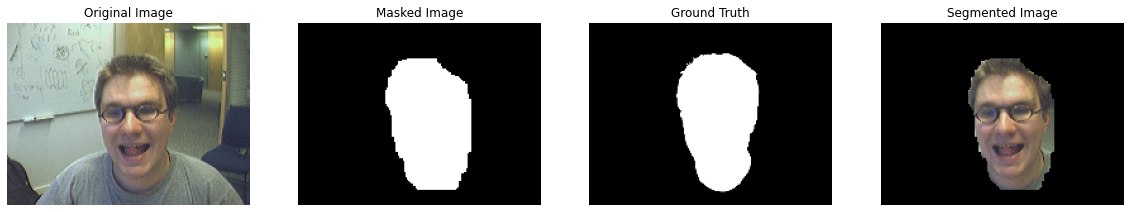

Accuracy :  0.9662543402777778
Jacard Similarity :  0.9018668787115478
Dice Similarity :  0.9504435797999062
CPU times: user 1min 33s, sys: 37 s, total: 2min 10s
Wall time: 1min 21s


In [102]:
%%time
filename = "../images/"+ original_images[23]
ground_truth = "../ground_truth/"+ground_truth_images[23]
GrabCut(filename, ground_truth, 1,100, 30,5)